import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
**How many clusters of birthplaces emerge?**

# Imports

In [228]:
import warnings
from clustergram import Clustergram
import urbangrammar_graphics as ugg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import pandas
import geopandas as gpd
from shapely.geometry import shape, Point
import pandas as pd
import numpy as np
from numpy import savetxt
from haversine import haversine, Unit
from functions import *
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Player info
player_df = pd.read_csv("data/player_gdf.csv", index_col=0)
player_gdf = gpd.read_file("data/player_gdf.geojson")[['fullName', 'city_province', 'geometry']]

In [3]:
# shape of North America to plot data 
us_can_gdf = gpd.read_file("data/full_us_can_geometry.geojson", driver='GeoJSON')

## Data Engineering

In [4]:
# just player coords
player_coords = player_df[['fullName', 'Lat', 'Lng']]

In [5]:
# flipping the lat and longitude for the player_gdf
player_gdf['geometry'] = [Point(coord.y, coord.x) for coord in player_gdf['geometry']]

# Clustergram

In [91]:
data = player_coords.drop(columns=['fullName'])

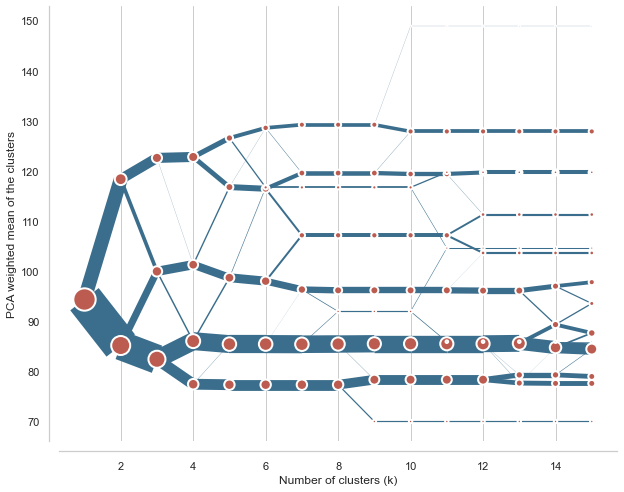

In [92]:
cgram = fit_plot_clustergram(data, end_range=16)

## Analyzing the optimal number of clusters

In [93]:
statistical_tests_values, statistical_tests_rec_cluster = evaluate_num_of_clusters(cgram)

In [97]:
statistical_tests_values

array([[1.20937601],
       [0.62297262],
       [0.00845454],
       [0.        ],
       [0.26854397],
       [0.41314414],
       [0.57427331],
       [0.6116543 ],
       [0.71232097],
       [0.932808  ],
       [1.04461046],
       [1.18999627],
       [1.26394755],
       [1.48184195]])

In [95]:
statistical_tests_rec_cluster

15

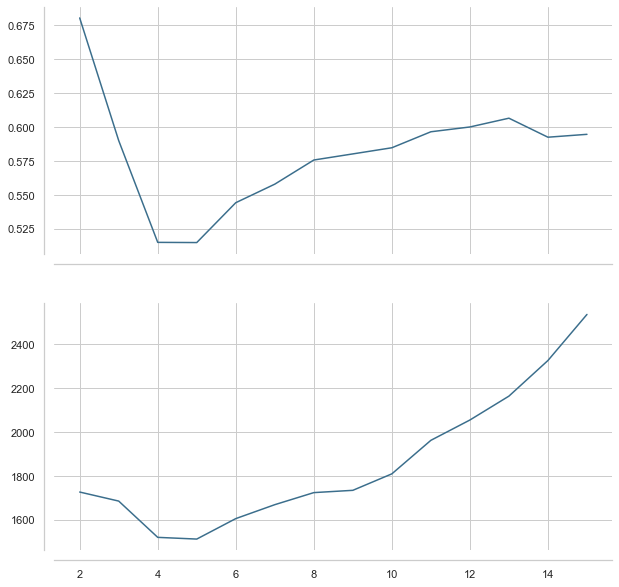

In [96]:
visualize_num_of_clusters(cgram)

We could cluster this in very small, or very large number of clusters. Based on the clustergram graph, I think **2 clusters makes the most sense**. At 3 and >9 clusters, most of the new divisions are very narrowly different from the previous iteration.

# Cluster the data

## Kmeans

In [226]:
# adjusting the data to be an array
X = np.array(player_coords[['Lat', 'Lng']])
# applying Kmeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# adding labels to player_gdf
player_gdf['player_cluster'] = kmeans.labels_

In [47]:
player_gdf_w_centroids = add_kmeans_centroids_to_gdf(player_gdf, kmeans)

Text(0.5, 1.0, "Optimal Clustering of NHL Players' Birthplaces into 2 Clusters (with centroids)")

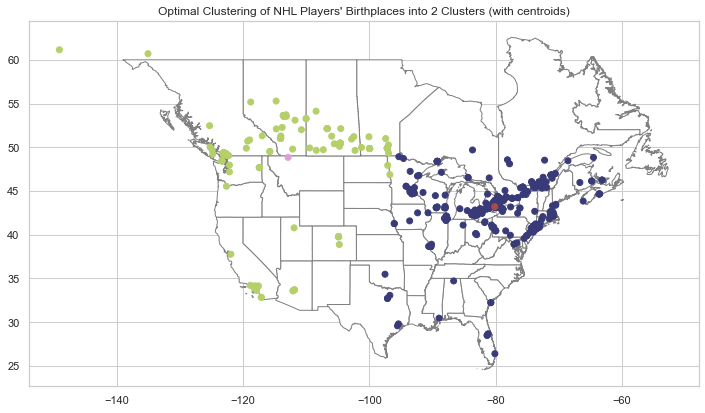

In [48]:
# the mis-colored dots in the middle of the larger clusters are the centroids of those clusters
plot_clusters(us_can_gdf, player_gdf_w_centroids, "player_cluster")
plt.title("Optimal Clustering of NHL Players' Birthplaces into 2 Clusters (with centroids)")
# plt.savefig("pictures/player_gdf_w_centroids.png", bbox_inches='tight', pad_inches=0.2)

## DBSCAN

I'm using this clustering algorithm in order to find more local clusters that will leave out outliers and make this more coherent (not many people would group florida with quebec city players but that's what the kmeans algorithm did)

In [32]:
dbscan_model = DBSCAN(eps=0.8, min_samples=10)
dbscan_yhat = dbscan_model.fit_predict(X)
dbscan_clusters = np.unique(dbscan_yhat)
player_gdf['player_cluster_dbscan'] = dbscan_yhat

<AxesSubplot:>

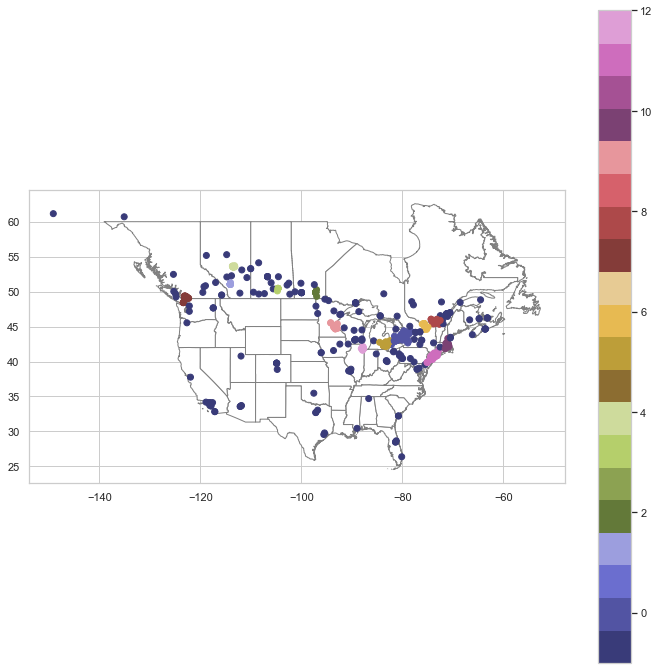

In [35]:
plot_clusters(us_can_gdf, player_gdf, "player_cluster_dbscan", include_legend=True)

You can see clusters a little better here but I feel that it's quite arbitrary with what parameters you choose, especially since there are so many different opinions about which clusters are real and which ones aren't.

### Finding clusters by using algorithm multiple times with different parameters

The goal here is to find **consistent** clusters that emerge over multiple parameter choices. To do this, I will find the cities that are found in multiple different parameters of the DBSCAN model. We will consider these places together as clusters.

In [36]:
# where I will store my data
noisey_data_df = pd.DataFrame()
noisey_data_df = player_df[['fullName', 'city_province']]

In [37]:
# find clustered data for a set of parameters, add to df
for eps in range(4, 14, 2):
    new_eps = eps/10
    for min_sample in range(5, 20, 5):
        noisey_data = run_cluster_determine_noise(new_eps, min_sample, X)
        col_name = f"Test{new_eps}_{min_sample}"
        noisey_data_df[col_name] = noisey_data

In [38]:
# Adding sum of cluster to df
cluster_sum = noisey_data_df.sum(axis=1)
noisey_data_df['cluster_sum'] = cluster_sum

In [63]:
birthplace_cluster_df = pd.DataFrame(noisey_data_df.groupby('city_province').cluster_sum.mean())
# 183 of the birthplaces are in 2/3 of the clusters created by DBSCAN
cluster_num_cutoff = round((15/3)*2) # a player can be in at most 15 clusters
in_most_cluster_df = birthplace_cluster_df[birthplace_cluster_df['cluster_sum'] >= cluster_num_cutoff]

In [40]:
# retrieve coordinates for each player passing cutoff
player_gdf_dbscan_cluster = player_gdf[player_gdf['city_province'].isin(in_most_cluster_df.index)]

# Analyzing the clusters 

## KMeans

How many players are in each cluster?

In [49]:
# clusters: 0 = east coast, 1 = west coast
# 2-3x more players in cluster 0 (east coast) than other clusters
player_gdf.player_cluster.value_counts()

0    420
1    162
Name: player_cluster, dtype: int64

## DBSCAN

How many players are in each cluster?

In [50]:
# this shows which cities are well represented
player_gdf_dbscan_cluster.city_province.value_counts()

Toronto,ON             27
Calgary,AB             16
London,ON              12
Edmonton,AB            10
Winnipeg,MB            10
                       ..
Oxford,MI               1
Tarrytown,NY            1
E. Weymouth,MA          1
Park Ridge,IL           1
Bloomfield Hills,MI     1
Name: city_province, Length: 183, dtype: int64

### Determining number of clusters for new grouping of data

In [98]:
# adjusting the data to be an array
dbscan_coords = player_coords[player_coords['fullName'].isin(player_gdf_dbscan_cluster.fullName)]
X_dbscan = dbscan_coords[['Lat', 'Lng']]

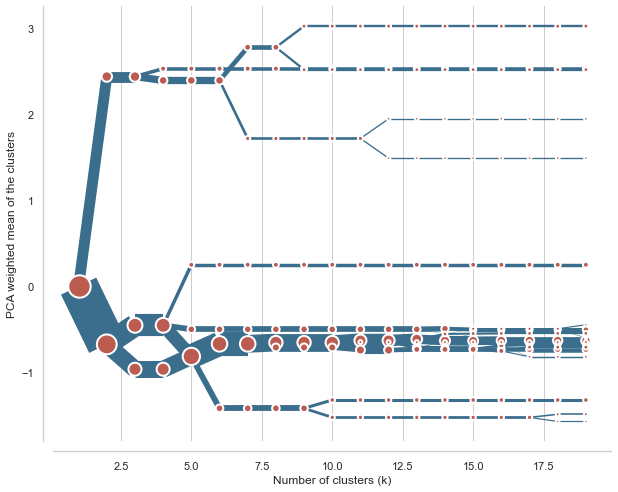

In [83]:
cgram_post_dbscan = fit_plot_clustergram(X_dbscan, end_range=20)

In [84]:
evaluate_num_of_clusters(cgram_post_dbscan)

(array([[1.0364245 ],
        [0.06404083],
        [0.        ],
        [0.43357273],
        [0.68185885],
        [0.81746457],
        [0.90940856],
        [1.05347058],
        [1.17736776],
        [1.21420052],
        [1.36867565],
        [1.56110092],
        [1.59437848],
        [1.60674838],
        [1.64872291],
        [1.75345286],
        [1.79361914],
        [1.86775299]]),
 19)

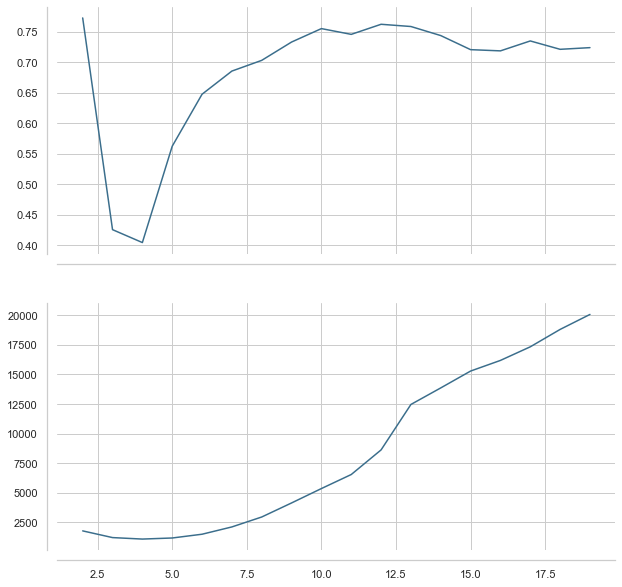

In [85]:
visualize_num_of_clusters(cgram_post_dbscan)

The more clusters, the better the model fits. However, I think that is slightly too specific for our taste. The last meaningful split in the clustergram graph occurs at 12, so we will use **12 clusters** when grouping our modified data.

### Grouping players into cities again (using kmeans, 12 clusters)

In [100]:
# applying Kmeans
kmeans_dbscan = KMeans(n_clusters=12, random_state=0).fit(X_dbscan)
# adding labels to player_gdf
player_gdf_dbscan_cluster['player_cluster'] = kmeans_dbscan.labels_

<AxesSubplot:>

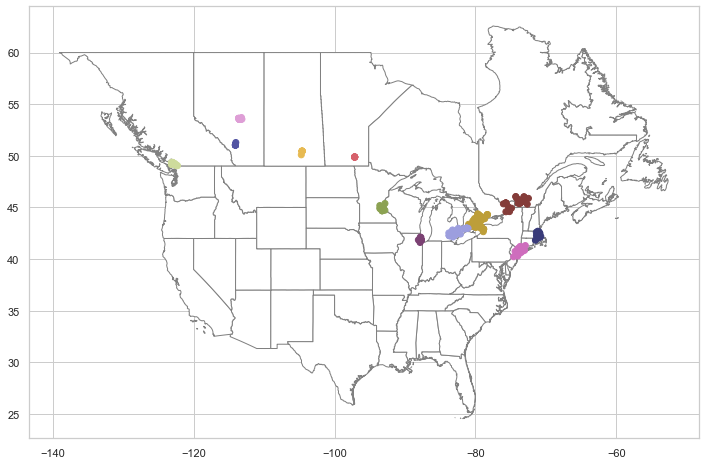

In [102]:
# interesting that ottawa and montreal are together 
plot_clusters(us_can_gdf, player_gdf_dbscan_cluster, "player_cluster")

#### Assigning names to the clusters

In [150]:
player_df_dbscan = player_df[player_df['city_province'].isin(player_gdf_dbscan_cluster.city_province)]

In [177]:
vancouver = player_df_dbscan[player_df_dbscan['city_province'] == 'Vancouver,BC'][['birthCity', 'Lat', 'Lng']].iloc[0]
boston = vancouver = player_df_dbscan[player_df_dbscan['city_province'] == 'Boston,MA'][['birthCity', 'Lat', 'Lng']].iloc[0]
detroit = player_df_dbscan[player_df_dbscan['city_province'] == 'Detroit,MI'][['birthCity', 'Lat', 'Lng']].iloc[0]
minneapolis = player_df_dbscan[player_df_dbscan['city_province'] == 'Minneapolis,MN'][['birthCity', 'Lat', 'Lng']].iloc[0]
toronto = player_df_dbscan[player_df_dbscan['city_province'] == 'Toronto,ON'][['birthCity', 'Lat', 'Lng']].iloc[0]
saskatchewan = player_df_dbscan[player_df_dbscan['city_province'] == 'Regina,SK'][['birthCity', 'Lat', 'Lng']].iloc[0]
montreal = player_df_dbscan[player_df_dbscan['city_province'] == 'Montreal,QC'][['birthCity', 'Lat', 'Lng']].iloc[0]
winnipeg = player_df_dbscan[player_df_dbscan['city_province'] == 'Winnipeg,MB'][['birthCity', 'Lat', 'Lng']].iloc[0]
chicago = player_df_dbscan[player_df_dbscan['city_province'] == 'Chicago,IL'][['birthCity', 'Lat', 'Lng']].iloc[0]
nyc = player_df_dbscan[player_df_dbscan['city_province'] == 'Brooklyn,NY'][['birthCity', 'Lat', 'Lng']].iloc[0]
edmonton = player_df_dbscan[player_df_dbscan['city_province'] == 'Edmonton,AB'][['birthCity', 'Lat', 'Lng']].iloc[0]
calgary = player_df_dbscan[player_df_dbscan['city_province'] == 'Calgary,AB'][['birthCity', 'Lat', 'Lng']].iloc[0]
major_city_coords = [vancouver, boston, detroit, minneapolis, toronto, saskatchewan, montreal, winnipeg,
                    chicago, nyc, edmonton, calgary]

In [206]:
# new df
cluster_count_df = pd.DataFrame(player_gdf_dbscan_cluster.groupby('player_cluster').player_cluster.mean())
num_of_players_in_clusters = player_gdf_dbscan_cluster.player_cluster.value_counts(sort=False)
cluster_count_df['Num_of_players'] = num_of_players_in_clusters

In [208]:
# finding closest city to each cluster_center
cluster_names = []
for idx, cluster in enumerate(kmeans_dbscan.cluster_centers_):
    city_name = None
    shortest_dist = 1000000 # score to beat! 
    for city in major_city_coords:
        dist_to_city = haversine((cluster[0], cluster[1]), (city['Lat'], city['Lng']))
        if dist_to_city < shortest_dist:
            shortest_dist = dist_to_city
            city_name = city['birthCity']
    cluster_names.append(city_name)

In [209]:
final_cluster_names = [x if x != 'Brooklyn' else 'NYC' for x in cluster_names]
cluster_count_df['Cluster_name'] = final_cluster_names

In [211]:
# from https://stackoverflow.com/questions/52973106/sorting-dataframe-using-pandas-keeping-columns-intact
cluster_count_df.sort_values(by='Num_of_players', kind='mergesort', ascending=False) 

,player_cluster,Num_of_players,Cluster_name
player_cluster,,,
5,5,119,Toronto
2,2,51,Detroit
7,7,43,Montreal
4,4,27,Calgary
3,3,26,Minneapolis
0,0,23,Boston
10,10,21,NYC
11,11,18,Edmonton
1,1,17,Calgary


In [212]:
# how many players does this account for? What proportion of all NA NHL players?
pct_players_in_clusters = cluster_count_df['Num_of_players'].sum() / player_df.shape[0]
print(f"The 12 clusters represent {round(pct_players_in_clusters,2)}% of all North American NHL players")

The 12 clusters represent 0.65% of all North American NHL players


In [223]:
toronto_count = cluster_count_df[cluster_count_df['Cluster_name'] == 'Toronto']['Num_of_players'].values[0]
detroit_count = cluster_count_df[cluster_count_df['Cluster_name'] == 'Detroit']['Num_of_players'].values[0]

In [225]:
num_players_in_det_buf_tor = toronto_count + detroit_count
pct_players_in_det_buf_tor = num_players_in_det_buf_tor / player_df.shape[0]
print(f"The Detroit/Toronto/Buffalo cluster represents {round(pct_players_in_det_buf_tor,2)}% of all North American NHL players")

The Detroit/Toronto/Buffalo cluster represents 0.29% of all North American NHL players
